In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import statistics
import nltk
import string
from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
# from transformers import pipeline
import optuna
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import lightgbm as lgbm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import  CountVectorizer #bag-of-words vectorizer 
# Bert
import torch
from transformers import BertTokenizer, BertModel
from torch import nn
from tqdm import tqdm

%matplotlib inline
%run ./Metrics.py
#%run ./ESE527_project_setup.ipynb
#%run ./Text_Normalization_Function.ipynb #defining text normalization function

In [2]:
print("PyTorch version: ", torch.__version__)  # 打印PyTorch版本
print("CUDA available : ", torch.cuda.is_available())  # 检查CUDA是否可用
print('There are %d GPU(s) available.' % torch.cuda.device_count())
if torch.cuda.is_available():
    device = 'cuda:0' 
else:
    device = 'cpu'

PyTorch version:  2.4.1+cu124
CUDA available :  True
There are 1 GPU(s) available.


### Data preprocessing

In [ ]:
review_data=pd.read_csv(r"C:\Users\Chuxu\ESE527\googleplaystore_user_reviews.csv")
review_null = pd.DataFrame({'Null Values':review_data.isna().sum().sort_values(ascending=False),
'Percentage Null Values':(review_data.isna().sum().sort_values(ascending=False))/(review_data.shape[0])*(100)})

In [6]:
def remove_punc_stopword(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    remove_punc = [word for word in text if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word.lower() for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

def categorize_Sentiment(sentiment):
    if sentiment =='Positive' :
        return 2
    elif sentiment == 'Neutral':
        return 1
    elif sentiment == 'Negative':
        return 0
    else:
        return np.nan  
    
def get_data(df,row_number,sentence_len):
    review_data_sample=df.dropna()
    review_data_sample=review_data_sample.iloc[:row_number,] 
    review_data_sample['Rating Interval'] = review_data_sample['Sentiment'].apply(categorize_Sentiment)
    #review_data_sample['Translated_Review']=normalize_corpus(review_data_sample['Translated_Review']) 
    review_data_sample['Translated_Review'] = review_data_sample['Translated_Review'].apply(remove_punc_stopword)
    review_data_sample['Translated_Review'] = review_data_sample['Translated_Review'].str.join(' ')
    
    for i in review_data_sample.index:
        if len(review_data_sample['Translated_Review'][i])<=sentence_len:
            review_data_sample=review_data_sample.drop(i)
    Review = review_data_sample["Translated_Review"]
    Rating = review_data_sample["Rating Interval"]
    train_comments, test_comments, train_labels, test_labels  = train_test_split(list(Review), list(Rating), test_size = 0.2, random_state = 68)
    return train_comments, test_comments, train_labels, test_labels

train_comments, test_comments, train_labels, test_labels  = get_data(review_data,10000,30)
print("length of train_comments:",len(train_comments)," length of train_comments:",len(test_comments))

length of train_comments: 5716  length of train_comments: 1430


#### Tfidf-Vectorizer Method

In [7]:
vectorizer = CountVectorizer()
Tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,1))
feature_matrix_TRAIN = Tfidf_vectorizer.fit_transform(train_comments).astype(float)
feature_matrix_TEST = Tfidf_vectorizer.transform(test_comments)

#### CountVectorizer + Tfidf-Transformer

In [39]:
vectorizer = CountVectorizer()
tf_idf_transformer = TfidfTransformer()
feature_matrix_TRAIN = tf_idf_transformer.fit_transform(vectorizer.fit_transform(normalized_train_reviews)).toarray()
feature_matrix_TEST = tf_idf_transformer.transform(vectorizer.transform(normalized_test_reviews)).toarray() 

In [133]:
def objective(trial):
    params = params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(feature_matrix_TRAIN,  train_labels)
    k_folds = 3
    cv_scores = cross_val_score(model, feature_matrix_TRAIN,  train_labels, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
clf_lgbm=lgbm.LGBMClassifier(**best_params)
clf_lgbm.fit(feature_matrix_TRAIN, train_labels)
y_pred_lgbm=clf_lgbm.predict(feature_matrix_TEST)

[I 2024-10-25 16:18:30,186] A new study created in memory with name: no-name-4b5f623c-91c1-4350-855a-0cb6b558179d


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.46462809937718375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46462809937718375
[LightGBM] [Warning] bagging_fraction is set=0.14349302782579393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14349302782579393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.46462809937718375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46462809937718375
[LightGBM] [Warning] bagging_fraction is set=0.14349302782579393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14349302782579393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memor

[LightGBM] [Warning] feature_fraction is set=0.2209030717155263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2209030717155263
[LightGBM] [Warning] bagging_fraction is set=0.8052548210738066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8052548210738066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Accuracy: 0.8109919571045576
Precision: 0.8146661351944733
Recall: 0.8109919571045576
F1 Score: 0.7984310616876991


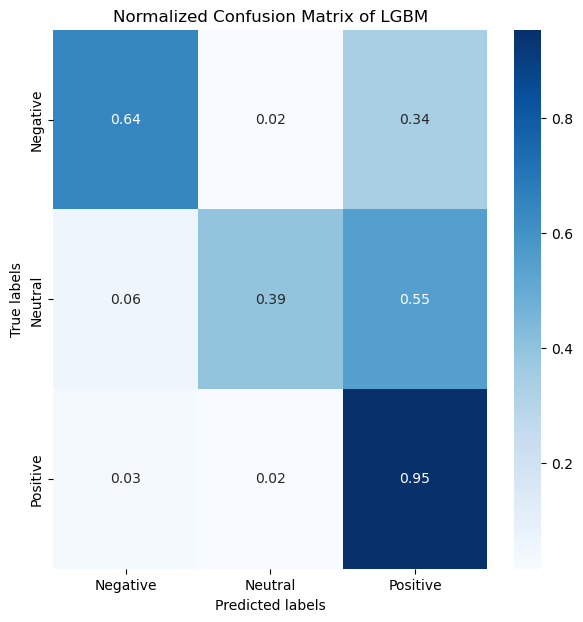

In [ ]:
cm(feature_matrix_TEST, test_labels, clf_lgbm,'LGBM',[ 'Negative', 'Neutral','Positive'])

### Bert

In [8]:
class BERTClassifier(nn.Module):
    # 初始化加载 bert-base-chinese 原型，即Bert中的Bert-Base模型
    def __init__(self, output_dim, pretrained_name='bert-base-uncased'):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_name) # 定义 Bert 模型
        self.mlp = nn.Linear(768, output_dim) # 外接全连接层
    def forward(self, tokens_X):
        res = self.bert(**tokens_X) # 得到最后一层的 '<cls>' 信息， 其标志全部上下文信息
        return self.mlp(res[1]) # res[1]代表序列的上下文信息'<cls>'，外接全连接层，进行情感分析 

"""
评估函数，用以评估数据集在神经网络下的精确度
"""
def evaluate(net, comments_data, labels_data):
    sum_correct, i = 0, 0
    while i <= len(comments_data):
        comments = comments_data[i: min(i + 8, len(comments_data))]
        tokens_X = tokenizer(comments, padding=True, truncation=True, return_tensors='pt').to(device=device)
        res = net(tokens_X)                                          # 获得到预测结果
        y = torch.tensor(labels_data[i: min(i + 8, len(comments_data))]).reshape(-1).to(device=device)
        sum_correct += (res.argmax(axis=1) == y).sum()              # 累加预测正确的结果
        i += 8
    return sum_correct/len(comments_data)                           # 返回(总正确结果/所有样本)，精确率

"""
训练bert_classifier分类器
"""
def train_bert_classifier(net, tokenizer, loss, optimizer, train_comments, train_labels, test_comments, test_labels,device, epochs):
    max_acc = 0.5  # 初始化模型最大精度为0.5
    # 先测试未训练前的模型精确度
    train_acc = evaluate(net, train_comments, train_labels)
    test_acc = evaluate(net, test_comments, test_labels)
    Train_acc=[]
    Test_acc=[]
    # 输出精度
    print('--epoch', 0, '\t--train_acc:', train_acc, '\t--test_acc', test_acc)
    # 累计训练18万条数据 epochs 次，优化模型
    for epoch in tqdm(range(epochs)):
        i, sum_loss = 0, 0  # 每次开始训练时， i 为 0 表示从第一条数据开始训练
        # 开始训练模型
        while i < len(train_comments):
            comments = train_comments[i: min(i + 8, len(train_comments))]  # 批量训练，每次训练8条样本数据

            # 通过 tokenizer 数据化输入的评论语句信息，准备输入bert分类器
            tokens_X = tokenizer(comments, padding=True, truncation=True, return_tensors='pt').to(device=device)
            # 将数据输入到bert分类器模型中，获得结果
            res = net(tokens_X)
            # 批量获取实际结果信息
            y = torch.tensor(train_labels[i: min(i + 8, len(train_comments))]).reshape(-1).to(device=device)

            optimizer.zero_grad()  # 清空梯度
            l = loss(res, y)  # 计算损失
            l.backward()  # 后向传播
            optimizer.step()  # 更新梯度

            sum_loss += l.detach()  # 累加损失
            i += 8  # 样本下标累加

        # 计算训练集与测试集的精度
        train_acc = evaluate(net, train_comments, train_labels)
        test_acc = evaluate(net, test_comments, test_labels)
        Train_acc.append(train_acc.cpu().numpy())
        Test_acc.append(test_acc.cpu().numpy())
       
        # 输出精度
        print('\n--epoch', epoch+1, '\t--loss:', sum_loss / (len(train_comments) / 8), '\t--train_acc:', train_acc,
              '\t--test_acc', test_acc)
        
        if test_acc > max_acc:# 如果测试集精度 大于 之前保存的最大精度，保存模型参数，并重设最大值
            max_acc = test_acc  # 更新历史最大精确度
            torch.save(net.state_dict(), 'bert.parameters') # 保存模型
    return Train_acc, Test_acc


In [9]:
net = BERTClassifier(output_dim=3).to(device)       # BERTClassifier分类器，因为最终结果为3分类，所以输出维度为3，代表概率分布并将模型存放到GPU中，加速计算
# 定义tokenizer对象，用于将评论语句转化为BertModel的输入信息
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loss = nn.CrossEntropyLoss()                                # 损失函数
optimizer = torch.optim.SGD(net.parameters(), lr=1e-4)      # 小批量随机梯度下降算法

In [10]:
Train_acc,Test_acc=train_bert_classifier(net, tokenizer, loss, optimizer, train_comments, train_labels, test_comments, test_labels, device, 15)

c:\Users\Chuxu\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


--epoch 0 	--train_acc: tensor(0.6053, device='cuda:0') 	--test_acc tensor(0.5972, device='cuda:0')


  0%|          | 0/15 [00:00<?, ?it/s]


--epoch 1 	--loss: tensor(0.8782, device='cuda:0') 	--train_acc: tensor(0.6260, device='cuda:0') 	--test_acc tensor(0.6182, device='cuda:0')


 13%|█▎        | 2/15 [02:56<19:07, 88.30s/it]


--epoch 2 	--loss: tensor(0.8441, device='cuda:0') 	--train_acc: tensor(0.6260, device='cuda:0') 	--test_acc tensor(0.6175, device='cuda:0')

--epoch 3 	--loss: tensor(0.7795, device='cuda:0') 	--train_acc: tensor(0.6695, device='cuda:0') 	--test_acc tensor(0.6608, device='cuda:0')


 20%|██        | 3/15 [04:24<17:33, 87.80s/it]


--epoch 4 	--loss: tensor(0.7126, device='cuda:0') 	--train_acc: tensor(0.7075, device='cuda:0') 	--test_acc tensor(0.6944, device='cuda:0')


 27%|██▋       | 4/15 [05:51<16:04, 87.68s/it]


--epoch 5 	--loss: tensor(0.6619, device='cuda:0') 	--train_acc: tensor(0.7350, device='cuda:0') 	--test_acc tensor(0.7112, device='cuda:0')


 33%|███▎      | 5/15 [07:19<14:37, 87.77s/it]


--epoch 6 	--loss: tensor(0.6196, device='cuda:0') 	--train_acc: tensor(0.7509, device='cuda:0') 	--test_acc tensor(0.7217, device='cuda:0')


 40%|████      | 6/15 [08:48<13:15, 88.36s/it]


--epoch 7 	--loss: tensor(0.5801, device='cuda:0') 	--train_acc: tensor(0.7719, device='cuda:0') 	--test_acc tensor(0.7287, device='cuda:0')


 47%|████▋     | 7/15 [10:19<11:51, 88.98s/it]


--epoch 8 	--loss: tensor(0.5404, device='cuda:0') 	--train_acc: tensor(0.7997, device='cuda:0') 	--test_acc tensor(0.7580, device='cuda:0')


 53%|█████▎    | 8/15 [11:49<10:25, 89.37s/it]


--epoch 9 	--loss: tensor(0.4979, device='cuda:0') 	--train_acc: tensor(0.8191, device='cuda:0') 	--test_acc tensor(0.7720, device='cuda:0')


 60%|██████    | 9/15 [13:28<09:13, 92.25s/it]


--epoch 10 	--loss: tensor(0.4545, device='cuda:0') 	--train_acc: tensor(0.8394, device='cuda:0') 	--test_acc tensor(0.7783, device='cuda:0')


 67%|██████▋   | 10/15 [15:05<07:49, 93.96s/it]


--epoch 11 	--loss: tensor(0.4123, device='cuda:0') 	--train_acc: tensor(0.8523, device='cuda:0') 	--test_acc tensor(0.7881, device='cuda:0')


 73%|███████▎  | 11/15 [16:41<06:18, 94.53s/it]


--epoch 12 	--loss: tensor(0.3714, device='cuda:0') 	--train_acc: tensor(0.8621, device='cuda:0') 	--test_acc tensor(0.7895, device='cuda:0')


 87%|████████▋ | 13/15 [19:54<03:10, 95.42s/it]


--epoch 13 	--loss: tensor(0.3327, device='cuda:0') 	--train_acc: tensor(0.8716, device='cuda:0') 	--test_acc tensor(0.7888, device='cuda:0')

--epoch 14 	--loss: tensor(0.2943, device='cuda:0') 	--train_acc: tensor(0.9012, device='cuda:0') 	--test_acc tensor(0.8042, device='cuda:0')


 93%|█████████▎| 14/15 [21:29<01:35, 95.45s/it]


--epoch 15 	--loss: tensor(0.2623, device='cuda:0') 	--train_acc: tensor(0.9138, device='cuda:0') 	--test_acc tensor(0.8091, device='cuda:0')


100%|██████████| 15/15 [23:06<00:00, 92.44s/it]


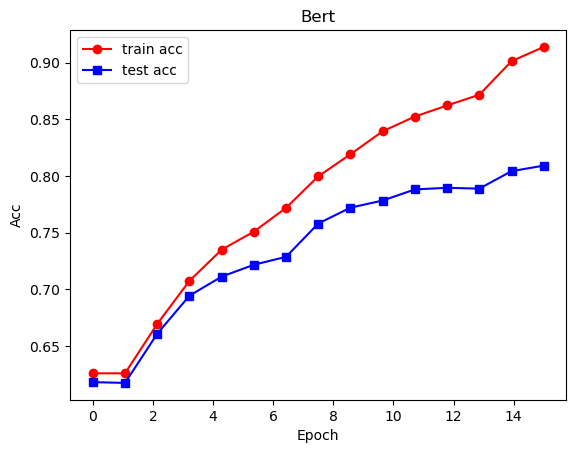

In [26]:
plt.plot(np.linspace(0,15,15), Train_acc, "ro-", label="train acc")
plt.plot(np.linspace(0,15,15), Test_acc, "bs-", label="test acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.title("Bert")
plt.show()

In [24]:
# 定义模型
net = BERTClassifier(output_dim=3)
net = net.to(device)
# 加载训练好的模型参数
#net.load_state_dict(torch.load('./bert.parameters'))

start = 1300
while start < 1350:
    comment = test_comments[start]
    token_X = tokenizer(comment, padding=True, truncation=True, return_tensors='pt').to(device)
    label = test_labels[start]                          # 实际结果
    result = net(token_X).argmax(axis=1).item()         # 得到预测结果
    
    print(comment)
    # Predicted results
    if result == 0:
        print('Predicted results: ', 0, '----》Negative', end='\t')
    elif result == 1:
        print(' Predicted results: ', 1, '----》Neutral', end='\t')
    else:
        print(' Predicted results: ', 2, '----》Positive', end='\t')
	# Actual results
    if label == 0:
        print('Actual results: ', 0, '----》Negative', end='\t')
    elif label == 1:
        print('Actual results: ', 1, '----》Neutral', end='\t')
    else:
        print('Actual results: ', 2, '----》Positive', end='\t')

    if result == label:
        print('Correct')
    else:
        print('Wrong')

    start += 1


sure bug people wanted type foreign language text careful share edited pdf foreign text nonalphabet somehow disappear yes see block space foreign text alphabetical text
 Predicted results:  2 ----》Positive	Actual results:  2 ----》Positive	Correct
guys removed preesing free space screen choose settings turn vault
 Predicted results:  2 ----》Positive	Actual results:  2 ----》Positive	Correct
would love helped monthly budget calculation though would also nice stock market options app
 Predicted results:  2 ----》Positive	Actual results:  2 ----》Positive	Correct
much news video format without transcripts biggest reason gets bad review many articles come problem loading content please try later trying later never works
 Predicted results:  2 ----》Positive	Actual results:  2 ----》Positive	Correct
like game alot fair certain level able compete someone levels high alot advantages would better fair
 Predicted results:  2 ----》Positive	Actual results:  2 ----》Positive	Correct
hate connection doesn